# PS2
  MACS 30100, Dr. Evans
  
  Jie Heng

## Problem 1

In [4]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib notebook

inc = np.loadtxt('incomes.txt')
inc.size


200

### (a) Plot a histogram

<IPython.core.display.Javascript object>


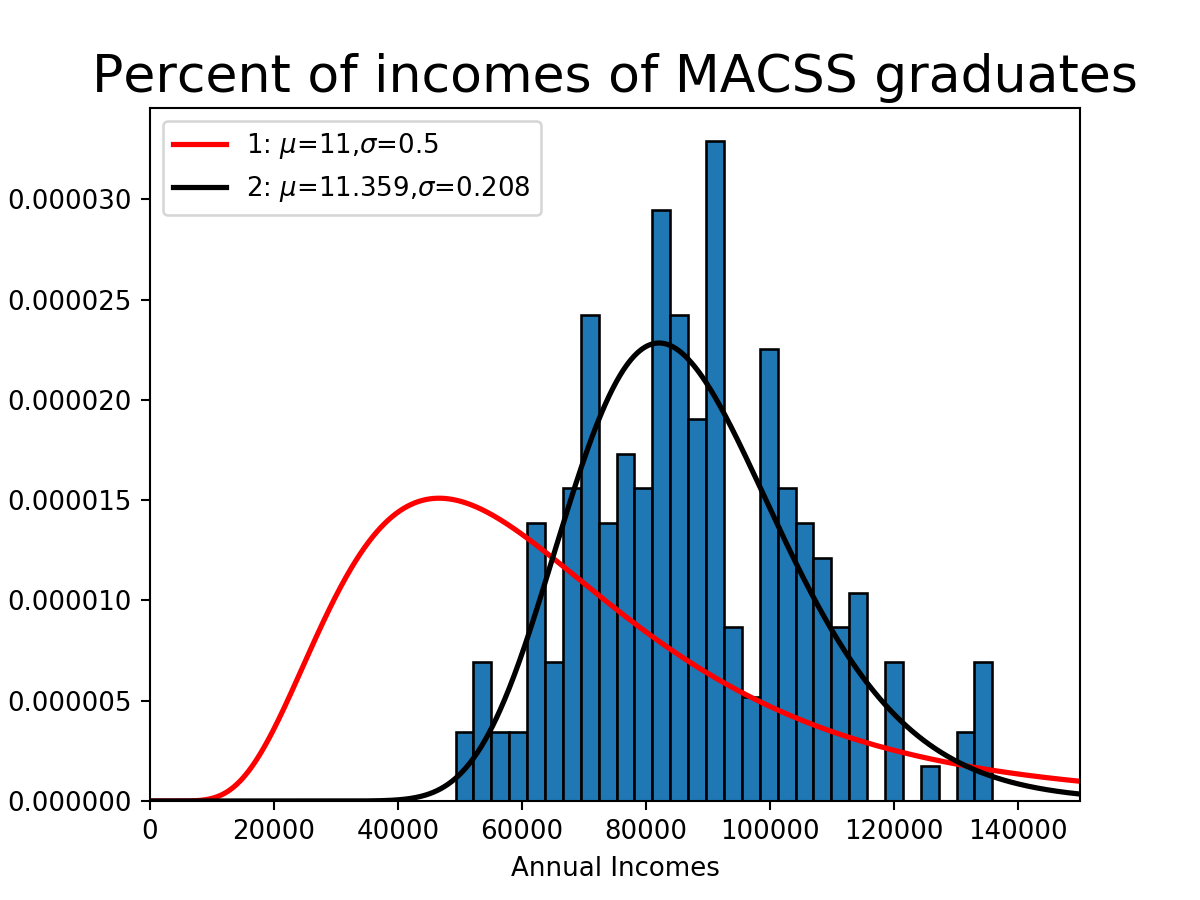

In [5]:
plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Observations')
plt.xlim([0, 150000])
plt.show()

### (b) Plot the lognormal PDF f(x|µ = 11.0, σ = 0.5) for 0 ≤ x ≤ 150, 000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [6]:
def truncnorm_pdf(xvals, mu, sigma):            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                (1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)))
    
    return pdf_vals

In [7]:
mu_1, sig_1= 11, 0.5
dist_inc = np.linspace(0.01, 150000, 1000)
plt.plot(dist_inc, truncnorm_pdf(dist_inc, mu_1, sig_1),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [8]:
def log_lik_truncnorm(xvals, mu, sigma):   
    pdf_vals = truncnorm_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('The Log-likelihood value is: ', log_lik_truncnorm(inc, mu_1, sig_1))

The Log-likelihood value is:  -2385.85699781


### (C) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ x ≤ 150, 000. Report the ML estimates for µ and σ, the value of the likelihood function, and the variance-covariance matrix.

In [9]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

params_init = np.array([mu_1, sig_1])
mle_args = (inc, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), bounds = 
                       ((None, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('the ML estimates for µ and σ are: mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

the ML estimates for µ and σ are: mu_MLE= 11.3590244332  sig_MLE= 0.208178546322


In [10]:
plt.plot(dist_inc, truncnorm_pdf(dist_inc, mu_MLE, sig_MLE),
         linewidth=2, color='k', label='2: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [11]:
print('The log likelihood using MLE is', log_lik_truncnorm(inc, mu_MLE, sig_MLE))

The log likelihood using MLE is -2241.71930137


In [12]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[  2.52847936e-04  -2.76193937e-05]
 [ -2.76193937e-05   1.30452099e-04]]


### (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [13]:
log_lik_h0 = log_lik_truncnorm(inc, mu_1, sig_1)
log_lik_mle = log_lik_truncnorm(inc, mu_MLE, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0, ', h0 is rejected')

chi squared of H0 with 2 degrees of freedom p-value =  0.0 , h0 is rejected


### (e) With your estimated distribution of incomes for Chicago MACSS students from part (c), you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), What is the probability that you will earn more than 100,000? What is the probability that you will earn less than 75,000?

In [14]:
p_1 =  1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_2 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print("The probability that MACSS students will earn more than $100,000 is {:.2f} and \
the probability they earn less than $75,000 is {:.2f}.".format(p_1, p_2))

The probability that MACSS students will earn more than $100,000 is 0.23 and the probability they earn less than $75,000 is 0.26.


## Problem 2

### (a) Estimate (β0, β1, β2, β3, σ2) to maximize the likelihood of seeing the data in sick.txt. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [15]:
import pandas as pd
df =  pd.read_csv('sick.txt')

In [16]:
def get_error(sick, age, children, temp_winter, b0, b1, b2, b3):
    error_val = sick- b0 - b1 * age - b2 * children - b3 * temp_winter
    return error_val

def loglik_norm(sick, age, children, temp_winter, b0, b1, b2, b3, sigma):
    error_val = get_error(sick, age, children, temp_winter, b0, b1, b2, b3)
    N = len(error_val)
    log_lik_val = (-N/2) * np.log(2 * np.pi)-(N/2)*np.log(sigma**2)-\
                  (1/(2*sigma**2)) * np.sum(error_val**2)  
    return log_lik_val 

def crit_2(params,*args):
    b0, b1, b2, b3, sigma = params
    sick, age, children, temp_winter = args
    log_lik_val = loglik_norm(sick, age, children, temp_winter, b0, b1, b2, b3, sigma)
    
    return -log_lik_val

In [17]:
sick = df.sick
age = df.age
children = df.children
temp_winter = df.avgtemp_winter
params_init =  np.array([1,0,0,0,0.1])
mle_args = (sick, age, children, temp_winter)
results2 = opt.minimize(crit_2, params_init, args=(mle_args), method = 'L-BFGS-B', 
                       bounds = ((None, None), (None, None), (None, None), \
                                 (None, None), (1e-100, None)))
b02, b12, b22, b32, sigma2 = results2.x
loglik2 = loglik_norm(sick, age, children, temp_winter, b02, b12, b22, b32, sigma2)
print ('The  are', results2.x, 'for b0, b1, b2, b3 and sigma')
print ('The log likelihood is', loglik2)

The  are [ 0.2516448   0.01293346  0.40050112 -0.00999171  0.00301774] for b0, b1, b2, b3 and sigma
The log likelihood is 876.865063968


In [18]:
results2

      fun: -876.86506396810069
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.31785782,  64.58130883,   3.46177558,  52.46754426,   2.54182169])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 780
      nit: 65
   status: 0
  success: True
        x: array([ 0.2516448 ,  0.01293346,  0.40050112, -0.00999171,  0.00301774])

In [19]:
OffDiagNeg2 = np.eye(5)*2-1
vcv2 =results2.hess_inv.todense() * OffDiagNeg2
print('VCV(MLE) = ', vcv2)

VCV(MLE) =  [[  3.28723504e+03   3.39439985e+00  -2.04665420e+02   7.21446680e+01
    3.48479197e+02]
 [  3.39439985e+00   4.41825229e-02   7.14649006e-01  -5.30029279e-02
   -5.14528108e-01]
 [ -2.04665420e+02   7.14649006e-01   1.89701923e+01   4.22582855e+00
    2.36105403e+01]
 [  7.21446680e+01  -5.30029279e-02   4.22582855e+00   1.59471000e+00
   -7.56630714e+00]
 [  3.48479197e+02  -5.14528108e-01   2.36105403e+01  -7.56630714e+00
    3.75304676e+01]]


### (b) Use a likelihood ratio test to determine the probability that β0 = 1.0, σ2 = 0.01 and β1, β2, β3 = 0. That is, what is the likelihood that age, number of children, and average winter temperature have no eﬀect on the number of sick days?

In [20]:
log_lik_h0 = loglik_norm(sick, age, children, temp_winter, 1,0,0,0,0.1)
log_lik_mle = loglik_norm(sick, age, children, temp_winter, b02, b12, b22, b32, sigma2)
pval_h0 = 1.0 - sts.chi2.cdf(2 * (log_lik_mle - log_lik_h0), 5)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0, ', h0 is rejected')

chi squared of H0 with 5 degrees of freedom p-value =  0.0 , h0 is rejected
